## Stochastic model in Mueller et al., Cell 2017

The model is based on work presented in Maly and Borisy, 2001; Schaus et al., 2007; Weichsel and Schwarz, 2010. The two-dimensional simulations are set up as follows:

### Setup

$N$ filaments are initialized at uniformly random positions bounded by $0 <= x < L$ and $0 <= y < \frac{dw}{2}$, where $L$ is the length of the leading edge and $dw$ the width of the region where polymerization and branching occur. The orientations of the filaments are sampled uniformly from the $-90^\circ <= \theta < 90^\circ$ interval. In the paper, $dw$ width is taken to be ten times the width of an actin monomer (2.7 nm).

The elongation, branching, and capping rates of a given filament are computed using heaviside functions that take its position as argument.

### Time evolution

At time $t$, the simulation iterates over each filament that figures out if it is going to get capped, branched, or elongate. The kinetic rates specify Poisson distributions. For a given process, the simulation draws a random number of its associated distribution, and the process occurs if this number if greater than 0.5. The kinetic rates are calculated as follows:

#### Elongation

The rate of elongation is denoted by $\lambda_0$ and is constant over time. This rate is zero outside the polymerization region (width $dw$).

#### Branching

Branching is taken to be zeroth-order with respect to the number of barbed ends. In the model, the branching rate $\beta$ is equal to $\alpha_0 a(t)$, where $\alpha_0$ is the activation rate of a nucleation promoting factor (NPF) present at concentration $a(t)$. In turn, this quantity is related to the other processes like so:

\begin{align*}
\frac{\delta D}{\delta t} &= \alpha_0 a(t) D(t) - \kappa (t) D(t) \\
\frac{\delta a}{\delta t} &= \beta_0 - \alpha_0 a(t) D(t) \\
\end{align*}

Above, $D(t)$ is the concentration of barbed ends, $\kappa$ the capping rate, and $\beta_0$ the rate of NPF recruitment to the leading edge. The model assumes that $\beta_0$ is much faster than branching and capping processes, so that $\frac{\delta a}{\delta t} \approx 0$. Thus, the branching rate turns out to be $\beta = \frac{\beta_0}{D(t)}$. In the simulation, branching rates decrease as the increasing number of barbed ends exhaust nucleation sites.

Daughter filaments are nucleated directly off the barbed ends of other filaments, and the angles between the daughter and mother filaments are sampled from a normal distribution centered around $70^\circ$ and with a $15^\circ$ standard deviation.

#### Capping

In the simulations, filaments get capped at a rate $\kappa_0$ when they are in the polymerization and branching region. This rate is significantly higher ($\kappa_1$) outside this region, so these filaments quickly lose contact with the leading edge.

One oddity in this model is that the associated Poisson rate does not take the density of barbed ends into account; capping is first-order with respect to the number of barbed ends.

#### Force-velocity

The network behaves like a Brownian ratchet, so the load is shared by the uncapped filaments:

\begin{align*}
V(F) &= V_0 \lambda_0 \delta \exp(\frac{-F \delta}{k_B T D(t)}) \\
\end{align*}

At the end of each iteration in the simulation, the leading edge moves $V(F) dt$, where $dt$ is the time interval in the simulation.

### Implementation

One of the authors shared his Python code on [Github](https://github.com/gszep/lamellipodium). I cloned the repository and rewrote the simulation code to become familiar with it. The module that does all the interesting stuff is [muellerSixt.py](https://jupyter.ucsf.edu:8888/edit/branched-networks/branchedNetwork.py). Below, we specify parameter values for a simulation run:

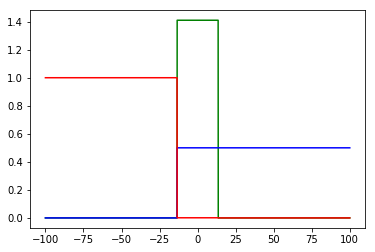

In [1]:
from muellerSixt import *
from numpy import pi, sin, cos, arccos, sqrt, median, convolve, diagonal, corrcoef, argmax, insert, cumsum, std, unique, savetxt, vstack, nanstd, nanmean, hstack, NaN, zeros, correlate, ones
from matplotlib.pyplot import *
from matplotlib.cm import *
%matplotlib inline

# Parameter values for the simulation.
N = 200 # initial number of filaments
dN = 2.7 # length of a monomer, in nm
filRange = 1000.0 # width of the leading edge, in nm
T = 10.0 # simulation run time, in s
dt = 0.001 # duration of time interval, in s
ds = 2.0 # frame rate
dw = 10 * dN # width of branching zone, in nm

# Rate functions.
# Elongation
lambdaRate = 141.0
def rLambda(x, y, t):
    return lambdaRate * heavisidePi(y, dw)

# Branching
betaRate = 0.5
def rBeta(x, y, t):
    return betaRate * heavisideTheta(y + dw / 2)

# Capping
kappaRate = 1.0
def rKappa(x, y, t):
    return 1000.0 * heavisideTheta(-y - dw / 2) + kappaRate * heavisidePi(y, dw)

# Plot rate functions.
plot(arange(-100, 100, 0.01), [rLambda(0, y, 0) / 100 for y in arange(-100, 100, 0.01)], 'g')
plot(arange(-100, 100, 0.01), [rBeta(0, y, 0) for y in arange(-100, 100, 0.01)], 'b')
plot(arange(-100, 100, 0.01), [rKappa(0, y, 0) / 1000 for y in arange(-100, 100, 0.01)], 'r')

We then initialize arrays indicating where the filaments are and their orientation. Then we create a branched network object and run the simulation.

/home/jiongyi/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 3000)

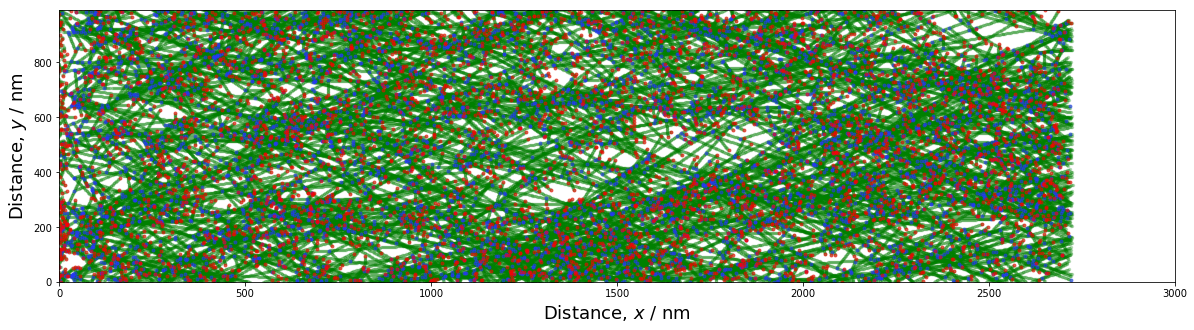

In [2]:
# Sample from uniform distribution given N filaments.
thetaDist = uniform(-pi, pi, size = N)
xDist = uniform(low = 0.0, high = filRange, size = N)
yDist = uniform(low = 0.0, high = dw / 2.0, size = N)

xInit = array([[x, y] for x, y in zip(xDist, yDist)])
dxInit = array([[dN * sin(theta), dN * cos(theta)] for theta in thetaDist])

# Initialize object.
n = network(rLambda, rBeta, rKappa, xSeed = xInit, dxSeed = dxInit, branchSigma = 15.0 * pi / 180, forceDirection= True, recordHistory = True)
n.exportData(dt, ds, n.tElapsed + T, Fext = 1.0e-1)

# Plot network.
xFil = n.getPositions(n.Monomers)
xBranch = n.getPositions(n.Branches)
xCap = n.getPositions(n.Caps)
figure(figsize=(20,5))
plot(xFil.T[1], xFil.T[0], 'g', marker = ".", linewidth = 0, ms = 5, alpha = 0.2)
if len(xBranch) != 0:
    plot(xBranch.T[1], xBranch.T[0], '#2737ff', marker = ".", linewidth = 0, ms = 6, alpha = 0.5)
if len(xCap) != 0:
    plot(xCap.T[1], xCap.T[0], '#ff0000', marker = ".", linewidth = 0, ms = 6, alpha = 0.5)
xlabel(r"Distance, $x$ / nm", fontsize = 18)
ylabel(r"Distance, $y$ / nm", fontsize = 18)
ylim(0, n.xBoundary); xlim(0, 3000)